In [4]:
%matplotlib inline
from pathlib import Path

import sys

import qiime2
import pandas as pd
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# sys.path.append('/Users/alchemist/Aakash/Diet/gut_brain_project/pipeline_trail_version/dokdo/')
# import api
import statsmodels.api as sm
import scipy

from tempfile import mkdtemp
from qiime2 import Artifact
from qiime2.plugins import demux, deblur, quality_filter, \
                          metadata, feature_table, alignment, \
                          phylogeny, diversity, emperor, feature_classifier, \
                          taxa, composition, dada2, vsearch, longitudinal, \
                          gneiss, songbird, aldex2, qurro, diversity_lib
from qiime2.plugins.diversity.pipelines import alpha,alpha_phylogenetic,beta,beta_phylogenetic

import matplotlib.pyplot as plt


pd.options.display.max_seq_items = 2000

Before beginning this tutorial, create a new directory and change to that directory.  
**make sure to change the path in `workdir`**

Input the variables below: 

In [5]:
workdir = !pwd
workdir = str(Path(workdir[0]).parents[0])

# read raw data

In [10]:
raw_sequences = qiime2.Artifact.import_data('SampleData[PairedEndSequencesWithQuality]', workdir+'/raw_data',view_type='CasavaOneEightSingleLanePerSampleDirFmt')

ValidationError: /Users/alchemist/Aakash/BonnGut/Microbiome_pipeline/raw_data is not a file.

In [ ]:
raw_sequences.save(workdir+'/demultiplexed_files/demultiplexed.qza') #saving demultipexed data

### read  metadata into `qiime2.Metadata` object

In [6]:
sample_metadata    = qiime2.Metadata.load(workdir+'/metadata/metadata.tsv')
sample_metadata_pd = sample_metadata.to_dataframe()
sample_metadata_pd.head()

,barcode-sequence,body-site,year,month,day,Person_ID,reported-antibiotic-usage,days-since-experiment-start
sample-id,,,,,,,,
L1S8,AGCTGACTAGTC,gut,2008.0,10.0,28.0,subject-1,Yes,0.0
L1S57,ACACACTATGGC,gut,2009.0,1.0,20.0,subject-1,No,84.0
L1S76,ACTACGTGTGGT,gut,2009.0,2.0,17.0,subject-1,No,112.0
L1S105,AGTGCGATGCGT,gut,2009.0,3.0,17.0,subject-1,No,140.0
L2S155,ACGATGCGACCA,left palm,2009.0,1.0,20.0,subject-1,No,84.0


In [13]:
sample_metadata.save(workdir+'/metadata/metadata.qza')

## Demultiplexing sequences

In [ ]:
# Looking at quality plots before joining 
demux_summary = demux.visualizers.summarize(raw_sequences)
demux_summary.visualization.export_data(workdir+'/demultiplexed_files/demux_summary')
demux_joined.visualization

In [ ]:
# Looking at quality plots after joining 
demux_joined_pairs = vsearch.methods.join_pairs(raw_sequences)
demux_joined = demux.visualizers.summarize(demux_joined_pairs.joined_sequences)
demux_joined.visualization.export_data(workdir+'/demultiplexed_files/demux_joined_summary')
demux_joined.visualization

## Denoising using dada2

In [15]:
sequences = dada2.methods.denoise_paired(raw_sequences,
                                  trim_left_f=17, #18
                                  trim_left_r=19, #21
                                  trunc_len_f=294, #278
                                  trunc_len_r=240, #211
                                  n_threads=0 
                                 )

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_paired.R /var/folders/bj/4d5l6xgx2fjgpp5jy9ql6jfh0000gn/T/tmp022078zd/forward /var/folders/bj/4d5l6xgx2fjgpp5jy9ql6jfh0000gn/T/tmp022078zd/reverse /var/folders/bj/4d5l6xgx2fjgpp5jy9ql6jfh0000gn/T/tmp022078zd/output.tsv.biom /var/folders/bj/4d5l6xgx2fjgpp5jy9ql6jfh0000gn/T/tmp022078zd/track.tsv /var/folders/bj/4d5l6xgx2fjgpp5jy9ql6jfh0000gn/T/tmp022078zd/filt_f /var/folders/bj/4d5l6xgx2fjgpp5jy9ql6jfh0000gn/T/tmp022078zd/filt_r 294 240 17 19 2.0 2.0 2 independent consensus 1.0 0 1000000



In [37]:
dada2_stats = sequences.denoising_stats
sequences.denoising_stats.save(workdir+"/dada2_files/dada2_stats.qza")
sequences.denoising_stats.view
#help(dada2_stats)

'/Users/alchemist/Aakash/BonnGut/Hannahs_study/qza_files/dada2_stats.qza'

## Saving Feature table & rep seq files

In [5]:
sequences.table.save(workdir+'/feature_table/table.qza')
sequences.representative_sequences.save(workdir+'/rep_seq/rep_seq.qza')

'/Users/alchemist/Aakash/BonnGut/Hannahs_study/qza_files/rep_seq.qza'

## Loading Feature table

<visualization: Visualization uuid: 64eeaf22-c8b8-4e92-a5fb-5add82dc3a16>

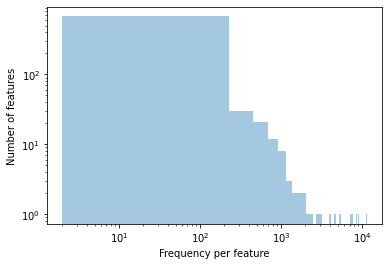

In [11]:
table   = Artifact.load(workdir+'/feature_table/table.qza')
rep_seq = Artifact.load(workdir+'/rep_seq/rep_seq.qza')
output_viz = feature_table.visualizers.summarize(table,sample_metadata)
output_viz.visualization.save(workdir+'/feature_table/table.qzv')
output_viz.visualization

## Generate a tree for phylogenetic diversity analyses

In [20]:
phylogenic_tree = phylogeny.pipelines.align_to_tree_mafft_fasttree(rep_seq)#,n_threads='auto')
phylogenic_tree.rooted_tree.save(workdir+'/phylo_tree/rooted_tree.qza')

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 /var/folders/bj/4d5l6xgx2fjgpp5jy9ql6jfh0000gn/T/qiime2-archive-7z2wq84t/a1d69b1f-7894-463e-8c76-6d2b65724420/data/dna-sequences.fasta

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTree -quote -nt /var/folders/bj/4d5l6xgx2fjgpp5jy9ql6jfh0000gn/T/qiime2-archive-vz7he0jn/872733ae-e70e-4784-bdc0-94ffc9f660d8/data/aligned-dna-sequences.fasta



'/Users/alchemist/Aakash/BonnGut/Microbiome_pipeline/phylo_tree/rooted_tree.qza'

# Taxonomy Assignment

In [21]:
gg_classifier = Artifact.load(workdir+'/taxonomy/classifier/classifier_ezbiocloud.qza')

ValueError: /Users/alchemist/Aakash/BonnGut/Microbiome_pipeline/taxonomy/classifier/classifier_ezbiocloud.qza does not exist.

In [7]:
taxonomy = feature_classifier.methods.classify_sklearn(reads = rep_seq,
                                                       classifier = gg_classifier)
taxonomy.classification.save(workdir+'/taxonomy/taxonomy_ezbiocloud.qza')

'/Users/alchemist/Aakash/BonnGut/Hannahs_study/taxonomy/taxonomy_ezbiocloud.qza'

In [8]:
taxonomy_classification = Artifact.load(workdir+'/taxonomy/taxonomy_ezbiocloud.qza')
taxonomy_vis = metadata.visualizers.tabulate(taxonomy_classification.view(qiime2.Metadata))
taxonomy_vis.visualization

<visualization: Visualization uuid: 7f9a1737-eb7d-4b88-8599-fa34df549c37>

In [12]:
taxa_bar_plot = taxa.visualizers.barplot(table, taxonomy_classification, sample_metadata)
taxa_bar_plot.visualization.export_data(workdir+'/taxonomy')